run<HDF5 file "run0133_droplets_10um_50mm.h5" (mode r)>: 17998 shots
run<HDF5 file "run0134_droplets_10um_50mm.h5" (mode r)>: 17998 shots
run<HDF5 file "run0135_droplets_10um_50mm.h5" (mode r)>: 17998 shots
run<HDF5 file "run0136_droplets_10um_50mm.h5" (mode r)>: 17998 shots
run<HDF5 file "run0137_droplets_10um_50mm.h5" (mode r)>: 17998 shots
(89990, 1000)
xray io average is 131.3920
xray stdev is 30.119423


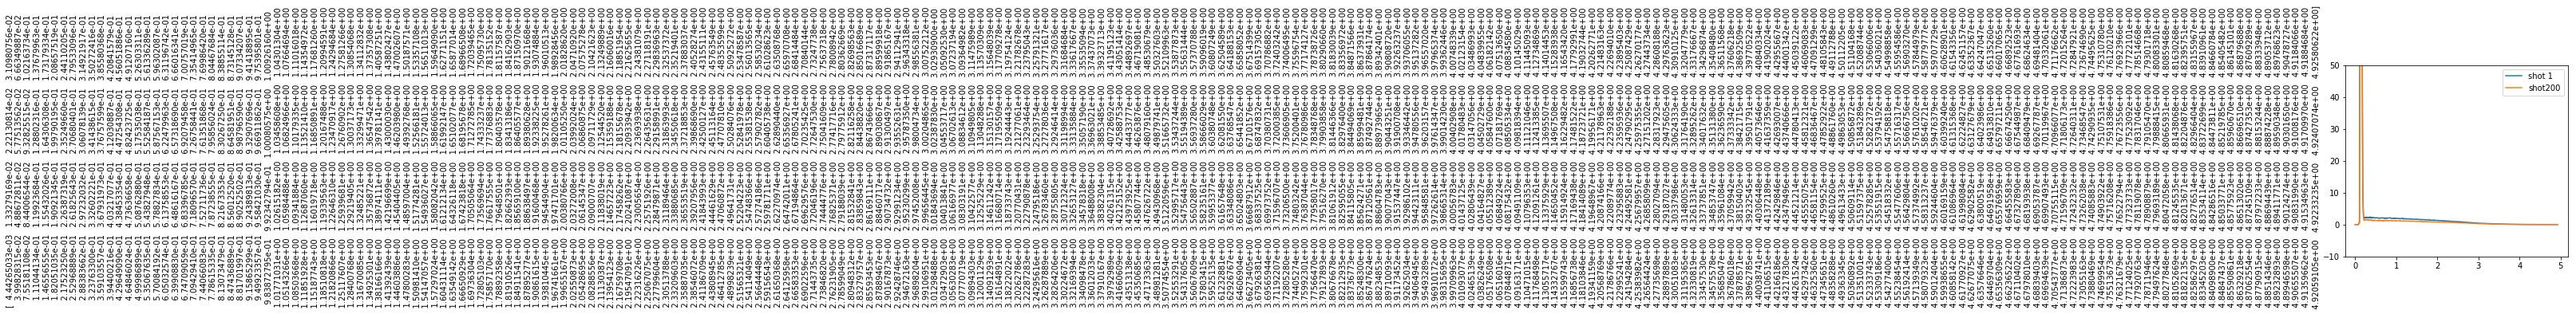

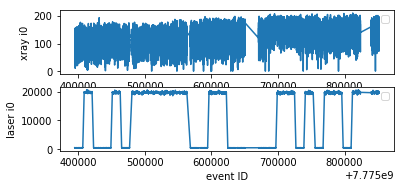

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
import h5py
import math
from argparse import ArgumentParser
from PIL import Image
import random
import sys
import numpy as np

#input parametres
#run_list=[109,110,111,112,113]
#run_list=[115,116,117]
#run_list=[119,120,121,122,123]
#run_list=[124,125,126]
#run_list=[127,128,129,130,131]
#run_list=[127,128,129,130,131,179,180]
#run_list=[133,134,135,136,137,182,183]
run_list=[133,134,135,136,137]
#run_list=[138,139,140,141,142,143]
#run_list=[145,146,147,149,163,164,220]
#run_list=[150,151,152,153,154,155,156,214,215,216]
#run_list=[157,158,159,160,161,162,177,178,201,202,203,204,217,218,219]
#run_list=[165,166,167,168,169,170,184,185,186,187,188,189,190,191,192,193,194,195]
#run_list=[171,172,173,205,206,207,208,209,210,211,212,213]

my_h5 =[]
data_folder= '/Volumes/APS2016/SwissFEL_data/res/hdf5/'
d=50 # distance in mm
start=133 #starting run
end=137 # ending run

def load_processed_data(run,path=None):
    '''
    loads data from processed h5
    '''
    
    if path is None:
        h5path = '/Volumes/APS2016/SwissFEL_data/res/hdf5/'
    else:
        h5path = path+'run0%d_droplets_10um_50mm.h5'%run_num
    h5file = h5py.File(h5path,'r')
    try:
        sum = h5file['JF7/2D_sum'][:]
    except KeyError:
        sum = np.zeros(( 4432, 4215 )) # bad solution: fix this in file instead
    Iq = h5file['JF7/I_Q'][:]
    r = h5file['JF7/Q_bins'][:]
    
    try:
        i0 = h5file['JF3/i0'].value
    except KeyError:
        i0 = h5file['JF7/i0'].value
    
    nshots = h5file['JF7/num_shots'].value

    try:
        nhits = np.int(h5file['JF7/num_hits'].value)
        sum_hits = h5file['JF7/2D_sum_hits'].value
        Iq_thr = h5file['JF7/I_threshold'].value
    except KeyError:
        nhits = 0
        sum_hits = np.zeros_like(sum)
        Iq_thr = 0
    
    laser_i0 = h5file['SARES20/i0'].value
    try:
        laser_on = h5file['SARES20/laser_on'].value
    except KeyError:
        laser_on = h5file['BERNINA/laser_on'].value
    event_ID = h5file['pulse_id'].value
          
    print('run%s: %d shots' % (run, h5file['JF7/num_shots'].value))
    h5file.close()
        
    return sum,Iq,r,int(nshots),sum_hits,Iq_thr,nhits,i0,laser_i0,laser_on,event_ID #maybe use dictionary here

# assume r does not change run to run
nshots   = 0 
Iq       = []                       # (shots, q_bins)
i0       = []                       # (shots) mean in ROI
laser_i0 = []                       # (shots) mean in ROI
laser_on = []                       # (shots) boolean value (True = on)
eventid = [] 
for run_num in run_list:
        
        # r_ prefix indicates per-run data
        try:
            run_path = '/Volumes/APS2016/SwissFEL_data/res/hdf5/'
            run = h5py.File(data_folder+'run0%d_droplets_10um_50mm.h5'%(run_num),'r')
            r_img, r_Iq, r, r_nshots, r_img_hits, thr, r_nhits, r_i0, r_laser_i0, r_laser_on, r_event_ID = load_processed_data(run, path=run_path)
        except (OSError, KeyError) as e:
            print(run_num, e)
            
        #img       += r_img
        Iq.append(r_Iq)
        nshots    += r_nshots
        #img_hits  += img_hits
        i0.append(r_i0)
        laser_i0.append(r_laser_i0)
        laser_on.append(r_laser_on)
        eventid.append(r_event_ID)
        
            
# finally, vstack the arrays so they appear like they came from one dataset (run)
Iq       = np.vstack(Iq)
i0       = np.concatenate(i0)
eventid  = np.concatenate(eventid)
laser_i0 = np.concatenate(laser_i0)
laser_on = np.concatenate(laser_on)
    
#convert q-bin to q
photon_energy=9500
detector_distance=0.1249
pixel_size=75E-6
ELEMENTARY_CHARGE = 1.602176634E-19 # C
SPEED_OF_LIGHT = 299792458 # m/s
PLANCK_CONSTANT = 6.62607015E-34 # Js
#q = q_scale(r, detector_distance=detector_distance, photon_energy=photon_energy*1000.0)
#print r_iq.shape()
wavelength = PLANCK_CONSTANT*SPEED_OF_LIGHT/(photon_energy*ELEMENTARY_CHARGE)
pixel_distances=r
q = 2.*np.pi*2.*np.sin(0.5*np.arctan2(pixel_distances*pixel_size, detector_distance))/(wavelength*1E10)

#geometric correction
thet = (q*wavelength*1e10/np.pi/4)
theta=np.arcsin(thet)
geo=(np.cos(theta))**3

print Iq.shape

Iq *=geo

#even_nos = [num for num in r_eventid if num % 8 == 0]  
even_eventid = [eventid[i] for i in range(len(eventid)) if i % 2 != 0] 
even_laseri0=  [laser_i0[i] for i in range(len(laser_i0)) if i % 2 != 0] 

i0_avg=np.average(i0)
i0_std=np.std(i0)
print ('xray io average is %.4f'%i0_avg) 
print ('xray stdev is %4f'%i0_std)

fig = plt.figure(figsize=[5,15])
plt.subplot(3,1,1)

plt.plot(q,Iq[0,:],label='shot 1')
#plt.plot(q,geo*Iq[0,:],label='geometric correction')
plt.ylim(-10,50)
plt.plot(q,Iq[200,:],label='shot200') #shot number n
plt.ylabel(q)
plt.legend()
plt.show()
#plot xray io
plt.subplot(3,1,2)
plt.plot(eventid,i0)
plt.ylabel('xray i0')
plt.xlabel('event ID')
plt.legend()

#plot laser_io
plt.subplot(3,1,3)
#plt.plot(eventid,laser_i0)
plt.plot(even_eventid,even_laseri0)
plt.ylabel('laser i0')
plt.xlabel('event ID')
plt.legend()
plt.show()

# convert intensity to photon/pix
Iq /= (0.001*photon_energy)
i0 /= (0.001*photon_energy)

[ 0.74012894  0.67222085  0.73611328 ...,  1.27961181  1.49185933
  1.11264745]
[ 0.13845931  0.13044891  0.13576313 ...,  0.16796009  0.16659937
  0.15347056]
median of Iq is
0.150302448941
average mean range is -0.0101 to 5.4825


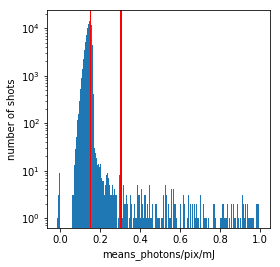

bg shots are 44995
Possible ice hits are 99
water (not ice) hits are 486
laser ON hit are 231
total shots are 89990


In [2]:
# find hits
#q-range for hit finding,q[200],q[400]=1.69 ,3.01 Å-1
r_min=200
r_max=400

#for ice
ice_thr = 0.5
filter_length = 1
q_min=1
q_max=4.5

from scipy.signal import medfilt
def find_hits(Iq, threshold=0.015, r_min=200, r_max=400):
    '''
    finds the shots that hit water droplets based on
    a simple threshold on the average over a q-range
    note: give Iq in photon/pix units/i0
    '''
    metric = np.average(Iq[:,r_min:r_max],axis=1)
    hits = metric>threshold
    return metric,hits

def find_bg(Iq, threshold=0.015, r_min=200, r_max=400):
    '''
    finds the shots that hit water droplets based on
    a simple threshold on the average over a q-range
    note: give Iq in photon/pix units/i0
    '''
    metric = np.average(Iq[:,r_min:r_max],axis=1)
    hits = metric<threshold
    return metric,hits

def find_ice(Iq, q, threshold=0.1, filter_length=5, q_min=1.0, q_max=4.5):
    '''
    finds the shots that hit ice droplets
    based on maximum gradient of median filtered intensities
    note: give Iq in photon/pix units/i0
    '''
    median_filtered_Iq = medfilt(Iq, (1, filter_length))

    ice_range_idx = (q > q_min) * (q < q_max)
    diff = np.abs(median_filtered_Iq[:,ice_range_idx] - median_filtered_Iq[:,np.roll(ice_range_idx, 1)])
    metric = np.max(diff, axis=1)
    hits = ( metric > threshold )
    return metric,hits

# normalise to i0
i0_avg = np.average(i0)
norm = i0/i0_avg
print norm
Iq_norm = Iq[:,:] / norm[:,None]
Iq_select=np.average(Iq_norm[:,r_min:r_max],axis=1)
print Iq_select
print 'median of Iq is'
print np.median(Iq_select)
bg_thr=np.median(Iq_select)
iq_thr=2*bg_thr

#plot histogram
vmin,vmax = np.amin(Iq_select),np.amax(Iq_select)
print 'average mean range is %.4f to %.4f'%(vmin,vmax)
bi,bf,db = vmin,1,0.005
hy,hx = np.histogram(Iq_select.flatten(),bins=np.arange(bi,bf+db,db))
fig = plt.figure(figsize=[4,4])
plt.bar(hx[:-1]-db/2.,hy,width=db,log=True)
low,high = iq_thr,iq_thr+0.001#set sorting threshold
lowbg,highbg = bg_thr,bg_thr+0.001#set sorting threshold
plt.axvspan(low,high,color='red')
plt.axvspan(lowbg,highbg,color='red')
plt.xlabel('means_photons/pix/mJ')
plt.ylabel('number of shots')
plt.show()

metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=r_min,r_max=r_max)
metric,bg = find_bg(Iq_norm,threshold=bg_thr,r_min=r_min,r_max=r_max)

#save bg
bg_hits = bg.sum()
print ('bg shots are %d'%bg_hits)

#find ice
ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)
#ice_hits = ice_hits.sum()
print ('Possible ice hits are %d'%ice_hits.sum())
# exclude ice hits
hits *= np.logical_not(ice_hits)

water_hits = hits.sum()
print ('water (not ice) hits are %d'%water_hits)
laseron_hits=  (hits & laser_on).sum()
print ('laser ON hit are %d'%laseron_hits)
#ice_hits = ice_hits.sum()
#print ('Possible ice hits are %d'%ice_hits)
total_shots=   nshots
print('total shots are %d'%total_shots)

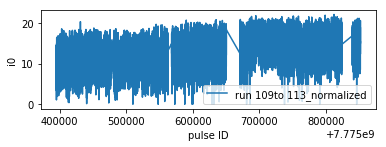

14.0900156122
3.17046559456


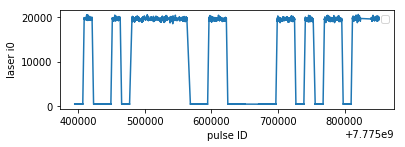

ice hits are 99
after weak x-ray hits removed
bg shots are 41401
hits are 461
ice hits are 91
after strong x-ray hits removed
bg shots are 41401
hits are 460
ice hits are 91
laser median intensity is 424.000000
laser std dev is 14.471804
after laser outliers removed
bg shots are now 41401
water (ice removed) hits are now 447
laser ON hit are 201
ice hits are now91


In [3]:
#exclude weak and strong x-ray and weak (and strong) laser
xray_i0_thr=2
laser_i0_thr=2

#plot xray io
fig_width = 3.5  # width in inches
fig_height = fig_width*2  # height in inches
fig_size =  [fig_width,fig_height]
plt.subplot(2,1,1)
plt.plot(eventid,i0,label='run 109to 113_normalized')
plt.xlabel('pulse ID')
plt.ylabel('i0')
plt.legend()
plt.show()
i0_avg=np.median(i0)
i0_std=np.std(i0)
print  i0_avg
print i0_std

#plot laser_io
plt.subplot(2,1,2)
#plt.plot(r_eventid,r_laser_i0)
plt.plot(even_eventid,even_laseri0)
plt.xlabel('pulse ID')
plt.ylabel('laser i0')
plt.legend()
plt.show()

#ice_hits=np.logical_not(ice_hits)
print ('ice hits are %d'%ice_hits.sum())
#ice_hits=np.logical_not(ice_hits)
# weak xray rejection
bg = bg & (i0 > i0_avg - xray_i0_thr*i0.std()) # remove weak x-ray shots
hits = hits & (i0 > i0_avg - xray_i0_thr*i0.std()) # remove weak x-ray shots
ice_hits = ice_hits & (i0 > i0_avg - xray_i0_thr*i0.std()) # remove weak x-ray shots
print('after weak x-ray hits removed')
print ('bg shots are %d'%bg.sum())
print ('hits are %d'%hits.sum())
print ('ice hits are %d'%ice_hits.sum())

# strong xray rejection
bg = bg & (i0 < i0_avg + xray_i0_thr*i0.std()) # remove weak x-ray shots
hits = hits & (i0 < i0_avg + xray_i0_thr*i0.std()) # remove weak x-ray shots
ice_hits = ice_hits & (i0 < i0_avg + xray_i0_thr*i0.std()) # remove weak x-ray shots
print('after strong x-ray hits removed')
print ('bg shots are %d'%bg.sum())
print ('hits are %d'%hits.sum())
print ('ice hits are %d'%ice_hits.sum())


# weak and strong laser rejection
l = laser_i0[laser_on.astype(np.bool)][:nshots]
laser_outliers = laser_on.astype(np.bool) & ((laser_i0 > (np.median(l) + laser_i0_thr*l.std())) | (laser_i0 < (np.median(l) - laser_i0_thr*l.std())))
hits *= np.logical_not(laser_outliers)
ice_hits *= np.logical_not(laser_outliers)
print ('laser median intensity is %2f'%np.median(l))
print ('laser std dev is %2f'%l.std())

print('after laser outliers removed')
print ('bg shots are now %d'%bg.sum())
water_hits = hits.sum()
print ('water (ice removed) hits are now %d'%water_hits)
laseron_hits=  (hits & laser_on).sum()
print ('laser ON hit are %d'%laseron_hits)
print ('ice hits are now%d'%ice_hits.sum())

In [4]:
#bg subtraction
taglist_hits,taglist_ice =[],[]

def subtract_background(Iq,hits,i0,nshots,misses=None):
    '''
    Calculates the average of missed shots and subtracts it as a background
    '''
    # in case there are no hits 
    taglist=[]
    if hits.sum() == 0:
        return None
    
    # calculate background based on normalised misses
    if misses is None:
        miss = np.logical_not(hits)
    else:
        miss = misses
    Iq_background = np.average(Iq[miss],axis=0,weights=i0[miss])
    
    # subtract background
    Iq_corr = np.zeros_like(Iq[hits])
    taglist.append(eventid[hits])
    for i in range(np.sum(hits)):
        norm = i0[hits][i]/np.average(i0[hits])
        Iq_corr[i] = Iq[hits][i]/norm - Iq_background/norm
    
    return Iq_corr,taglist
Iq_corr,taglist_hits = subtract_background(Iq,hits,i0,nshots,misses=bg) # Iq_corr same shape as Iq[hits]
Iq_corr_ice,taglist_ice= subtract_background(Iq,ice_hits,i0,nshots,misses=bg) # Iq_corr_ice same shape as Iq[ice_hits]

X=np.array(taglist_hits)
print X.shape
#print taglist_hits
#print taglist_ice
Y =X[0]
print Y.shape

(1, 447)
(447,)


(89990, 1000)
(447, 1000)
(91, 1000)


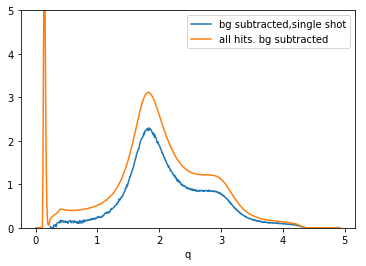

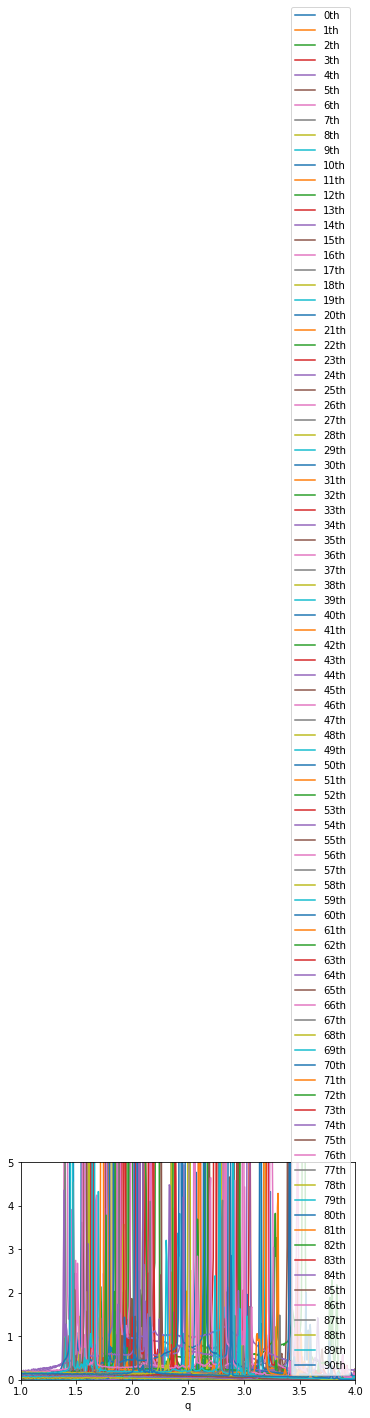

201
246
(246,)


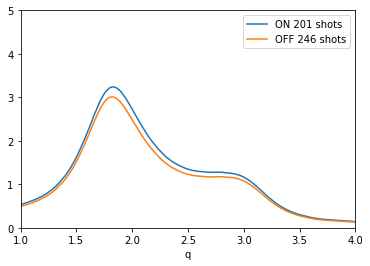

(1000,)


//anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


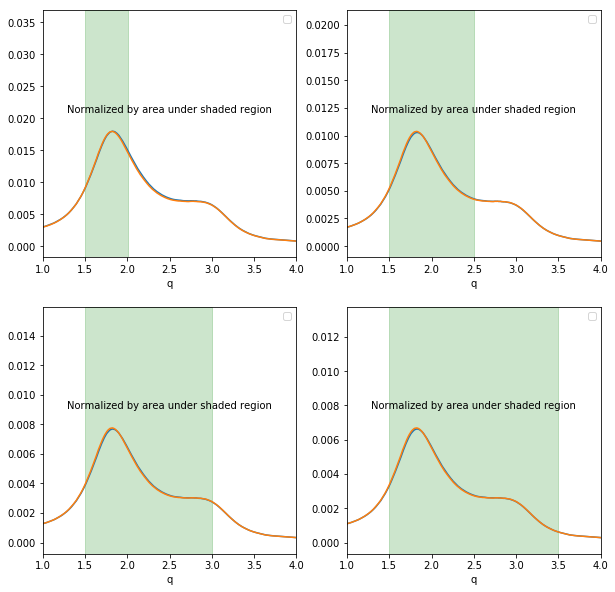

In [5]:
# averaging hits and normalization
print Iq.shape
print Iq_corr.shape
print Iq_corr_ice.shape
taglist_on,taglist_off=[],[]
#normalization function
def normalize(array, low, high, subtract=False):
    if subtract:
        n = np.max(array[low:high])
        m = array.min()
        norm_array = (array-m) / (n-m) # normalized between 0 and 1
    else:
        n = np.sum(array[low:high])
        norm_array = array / n # normalized to area
    return norm_array

if Iq_corr is not None:
    hit_avg = np.average(Iq_corr,axis=0)# axis zero is along the rows
else:
    hit_avg = np.zeros_like(np.average(Iq,axis=0))
    
if Iq_corr_ice is not None:
    hit_avg_ice = np.average(Iq_corr_ice,axis=0)# axis zero is along the rows
else:
    hit_avg_ice = np.zeros_like(np.average(Iq,axis=0))    

plt.plot(q,Iq_corr[0,:],label='bg subtracted,single shot')
plt.plot(q,hit_avg, label='all hits. bg subtracted')
#plt.plot(q,hit_avg_ice, label='all ice hits. bg subtracted')
plt.xlabel('q')
plt.ylim(0,5)
plt.legend()
plt.show()

for i in range(ice_hits.sum()):
    plt.plot(q,Iq_corr_ice[i,:],label='%dth'%i)
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(0,5)
plt.legend()
plt.show()    

#averaging OFF and ON hits
# in case there are no hits return en empty array
if hits.sum() > 0:
        # important: cast laser_on to boolean (otherwise it messes up the code -ask TJ)
        laser_on_hits = laser_on[hits].astype(bool)   
        laser_off_hits = np.logical_not(laser_on_hits)
        print laser_on_hits.sum()
        print laser_off_hits.sum()
 
        # laser on and off shots
        if (laser_on_hits.sum() > 0) and (laser_off_hits.sum() > 0):
            Iq_on_avg = np.average(Iq_corr[laser_on_hits],axis=0)
            taglist_on.append(Y[laser_on_hits])
            Iq_off_avg = np.average(Iq_corr[laser_off_hits],axis=0)
            taglist_off.append(Y[laser_off_hits])
        else:
            Iq_on_avg=np.zeros_like(np.average(Iq_corr,axis=0))
            Iq_off_avg=np.zeros_like(np.average(Iq_corr,axis=0))

print np.array(taglist_off)[0].shape
#plot avergage OFF AND ON HITS            
plt.plot(q,Iq_on_avg, label='ON %d shots'%laser_on_hits.sum())
plt.plot(q,Iq_off_avg, label='OFF %d shots'%laser_off_hits.sum())
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(0,5)
plt.legend()
plt.show()
print Iq_on_avg.shape
iq_off_array =[]

#NORMALIZE
fig = plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
#normalization q -range 1.5 Å-1 to 2 Å-1
r_min=175
r_max=241
Iq_on_norm = normalize(Iq_on_avg, r_min, r_max)
Iq_off_norm = normalize(Iq_off_avg, r_min, r_max)
iq_off_array.append(Iq_off_norm)
plt.plot(q,Iq_on_norm)
plt.plot(q,Iq_off_norm)
plt.axvspan(q[r_min],q[r_max],color='green',alpha=0.2)
plt.xlabel('q')
plt.xlim(1,4)
#plt.ylim(0,5)
plt.legend()
ax = plt.subplot(221)
ax.text(0.5, 0.60,'Normalized by area under shaded region',ha='center', va='center', transform=ax.transAxes,fontsize=10)
diff_signal_1 = Iq_on_norm-Iq_off_norm

plt.subplot(2,2,2)
#normalization q -range 1.5 Å-1 to 2.5 Å-1
r_min=175
r_max=314
Iq_on_norm = normalize(Iq_on_avg, r_min, r_max)
Iq_off_norm = normalize(Iq_off_avg, r_min, r_max)
iq_off_array.append(Iq_off_norm)
plt.plot(q,Iq_on_norm)
plt.plot(q,Iq_off_norm)
plt.axvspan(q[r_min],q[r_max],color='green',alpha=0.2)
plt.xlabel('q')
plt.xlim(1,4)
#plt.ylim(0,5)
plt.legend()
ax = plt.subplot(222)
ax.text(0.5, 0.60,'Normalized by area under shaded region',ha='center', va='center', transform=ax.transAxes,fontsize=10)
diff_signal_2 = Iq_on_norm-Iq_off_norm

plt.subplot(2,2,3)
#normalization q -range 1.5 Å-1 to 3 Å-1
r_min=175
r_max=398
Iq_on_norm = normalize(Iq_on_avg, r_min, r_max)
Iq_off_norm = normalize(Iq_off_avg, r_min, r_max)
iq_off_array.append(Iq_off_norm)
plt.plot(q,Iq_on_norm)
plt.plot(q,Iq_off_norm)
plt.axvspan(q[r_min],q[r_max],color='green',alpha=0.2)
plt.xlabel('q')
plt.xlim(1,4)
#plt.ylim(0,5)
plt.legend()
ax = plt.subplot(223)
ax.text(0.5, 0.60,'Normalized by area under shaded region',ha='center', va='center', transform=ax.transAxes,fontsize=10)
diff_signal_3 = Iq_on_norm-Iq_off_norm

plt.subplot(2,2,4)
#normalization q -range 1.5 Å-1 to 3 Å-1
r_min=175
r_max=498
Iq_on_norm = normalize(Iq_on_avg, r_min, r_max)
Iq_off_norm = normalize(Iq_off_avg, r_min, r_max)
iq_off_array.append(Iq_off_norm)
plt.plot(q,Iq_on_norm)
plt.plot(q,Iq_off_norm)
plt.axvspan(q[r_min],q[r_max],color='green',alpha=0.2)
plt.xlabel('q')
plt.xlim(1,4)
#plt.ylim(0,5)
plt.legend()
ax = plt.subplot(224)
ax.text(0.5, 0.60,'Normalized by area under shaded region',ha='center', va='center', transform=ax.transAxes,fontsize=10)
diff_signal_4 = Iq_on_norm-Iq_off_norm
plt.show()


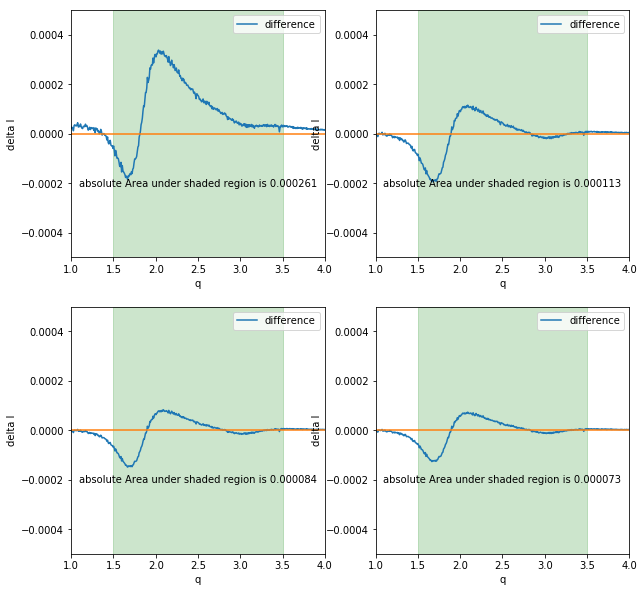

In [6]:
# pump-probe signal
low,high = 1.5,3.5#set q-range parameters for integration
zero=np.zeros(len(q))
areas=[]

#plot difference
fig = plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
difference=diff_signal_1
plt.plot(q,difference,label='difference')
mod_diff=abs(difference)
#area under curve (Delta I)
summation=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation += mod_diff[i]*(q[i+1]-q[i])
plt.plot(q,zero)
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
#plt.ylim(-0.0001,0.0001)
ax = plt.subplot(221)
ax.text(0.5, 0.30,'absolute Area under shaded region is %4f'%summation,ha='center', va='center', transform=ax.transAxes,fontsize=10)
areas.append(summation)

plt.subplot(2,2,2)
difference=diff_signal_2
plt.plot(q,difference,label='difference')
mod_diff=abs(difference)
#area under curve (Delta I)
summation=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation += mod_diff[i]*(q[i+1]-q[i])
plt.plot(q,zero)
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
#plt.ylim(-0.0001,0.0001)
ax = plt.subplot(222)
ax.text(0.5, 0.30,'absolute Area under shaded region is %4f'%summation,ha='center', va='center', transform=ax.transAxes,fontsize=10)
areas.append(summation)

plt.subplot(2,2,3)
difference=diff_signal_3
plt.plot(q,difference,label='difference')
mod_diff=abs(difference)
#area under curve (Delta I)
summation=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation += mod_diff[i]*(q[i+1]-q[i])
plt.plot(q,zero)
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
#plt.ylim(-0.0001,0.0001)
ax = plt.subplot(223)
ax.text(0.5, 0.30,'absolute Area under shaded region is %4f'%summation,ha='center', va='center', transform=ax.transAxes,fontsize=10)
areas.append(summation)

plt.subplot(2,2,4)
difference=diff_signal_4
plt.plot(q,difference,label='difference')
mod_diff=abs(difference)
#area under curve (Delta I)
summation=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation += mod_diff[i]*(q[i+1]-q[i])
plt.plot(q,zero)
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
#plt.ylim(-0.0001,0.0001)
ax = plt.subplot(224)
ax.text(0.5, 0.30,'absolute Area under shaded region is %4f'%summation,ha='center', va='center', transform=ax.transAxes,fontsize=10)
areas.append(summation)

plt.show()          

In [7]:
#save OFF shots

test=np.array(iq_off_array)
print test.shape
print areas
with open('OFFshots_run%d_to_%d_%d_mm.csv'%(start,end,d),'w') as out_file:
    out_string ='#area (1.5-3.5Å-1) under difference_1 is %5e'%areas[0]
    out_string+='\n'
    out_file.write(out_string)
    out_string ='#area(1.5-3.5Å-1) under difference_2 is %5e'%areas[1]
    out_string+='\n'
    out_file.write(out_string)
    out_string ='#area(1.5-3.5Å-1) under difference_3 is %5e'%areas[2]
    out_string+='\n'
    out_file.write(out_string)
    out_string ='#area(1.5-3.5Å-1) under difference_4 is %5e'%areas[3]
    out_string+='\n'
    out_file.write(out_string)
    out_string ='#q, Iq_off_avg,normalized_1,norm_2,norm_3,norm_4,diff_1,diff_2,diff_3,diff_4'
    out_string+='\n'
    out_file.write(out_string)
    for i in range(1000):
        out_string=''
        out_string+=str(q[i])
        out_string+=','+str(Iq_off_avg[i])
        out_string+=','+str(test[0,i])
        out_string+=','+str(test[1,i])
        out_string+=','+str(test[2,i])
        out_string+=','+str(test[3,i])
        out_string+=','+str(diff_signal_1[i])
        out_string+=','+str(diff_signal_2[i])
        out_string+=','+str(diff_signal_3[i])
        out_string+=','+str(diff_signal_4[i])
        out_string+='\n'
        out_file.write(out_string)

with open('Taglist_run%d_to_%d_%d_mm.csv'%(start,end,d),'w') as out_file:  
    out_string ='#OFF tags'
    out_string+='\n'
    out_file.write(out_string)
    for i in range(len(np.array(taglist_off)[0])):
        out_string=''
        out_string+=str(np.array(taglist_off)[0][i])
        out_string+='\n'
        out_file.write(out_string)
    out_string ='#ON tags'
    out_string+='\n'
    out_file.write(out_string)
    for i in range(len(np.array(taglist_on)[0])):
        out_string=''
        out_string+=str(np.array(taglist_on)[0][i])
        out_string+='\n'
        out_file.write(out_string)

(4, 1000)
[0.00026088264961585778, 0.00011266591177552848, 8.3904598472739765e-05, 7.2526345744309501e-05]


(1000, 10)


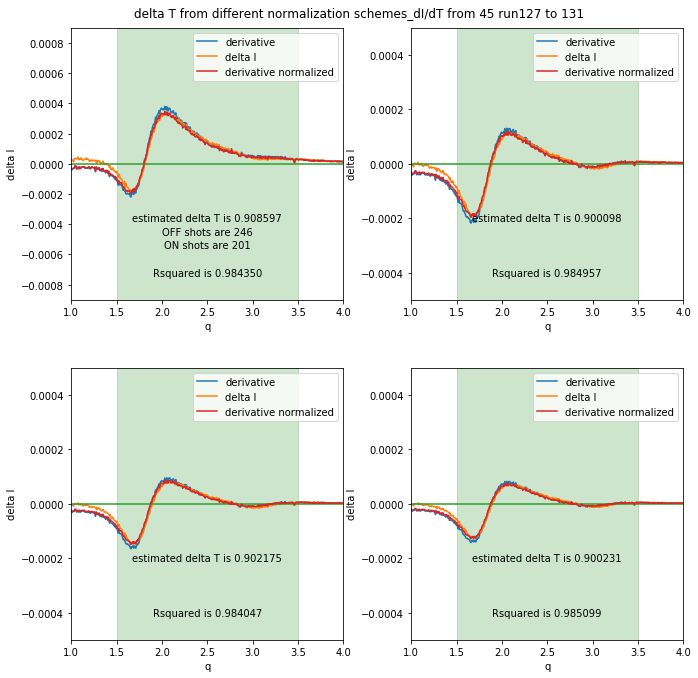

In [8]:
#delta_T based on linear regression
#Load OFF shots from different Temperature
d2=45 #mm
start2=127
end2=131
T_diff=.9
I2=np.loadtxt('OFFshots_run127_to_131_45_mm.csv',delimiter=',')
print I2.shape
fig = plt.figure(figsize=[10,10])

plt.subplot(2,2,1)
#NORMALIZATION SCHEME 1 
derivative=(I2[:,2]-test[0,:])/T_diff # DELTA I/DELTA T
plt.plot(q,derivative,label='derivative')
plt.plot(q,diff_signal_1,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*diff_signal_1[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=diff_signal_1
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.9e-3,0.9e-3)
ax = plt.subplot(221)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.25,'OFF shots are %d'%laser_off_hits.sum(),ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.20,'ON shots are %d'%laser_on_hits.sum(),ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,2)
#NORMALIZATION SCHEME 2
derivative=(I2[:,3]-test[1,:])/T_diff # DELTA I/DELTA T
diff=areas[1]
difference=diff_signal_2
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(222)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,3)
#NORMALIZATION SCHEME 3
derivative=(I2[:,4]-test[2,:])/T_diff # DELTA I/DELTA T
diff=areas[2]
difference=diff_signal_3
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(223)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,4)
#NORMALIZATION SCHEME 4
derivative=(I2[:,5]-test[3,:])/T_diff # DELTA I/DELTA T
diff=areas[3]
difference=diff_signal_4
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(224)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)
plt.suptitle('delta T from different normalization schemes_dI/dT from %d run%d to %d'%(d2,start2,end2))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.25, hspace=0.25)
#plt.savefig('delta_T_run%d_to_%d_%d_mm_comparedwith_run%d_to%d.pdf'%(start,end,d,start2,end2))
plt.show()

(1000, 10)


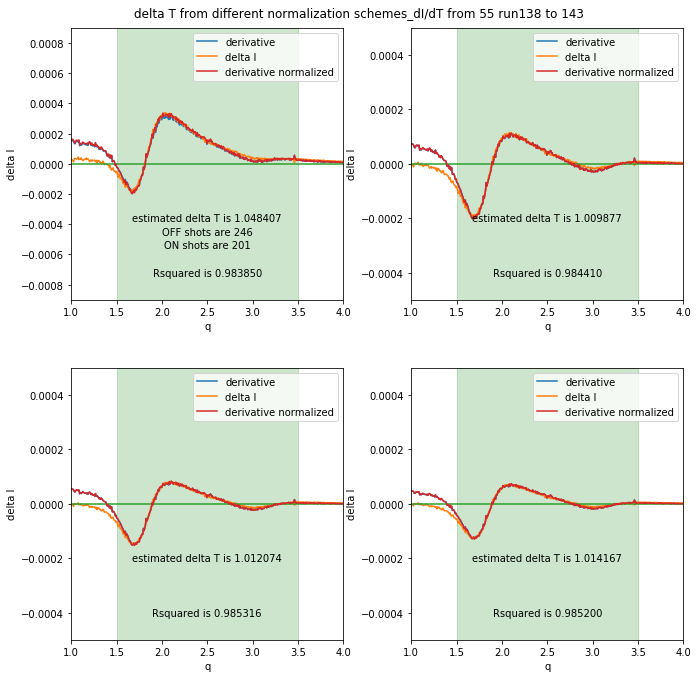

In [9]:
#delta_T based on linear regression
#Load OFF shots from different Temperature
d2=55 #mm
start2=138
end2=143
T_diff=-.805
I2=np.loadtxt('OFFshots_run138_to_143_55_mm.csv',delimiter=',')
print I2.shape
fig = plt.figure(figsize=[10,10])


plt.subplot(2,2,1)
#NORMALIZATION SCHEME 1 
derivative=(I2[:,2]-test[0,:])/T_diff # DELTA I/DELTA T
plt.plot(q,derivative,label='derivative')
plt.plot(q,diff_signal_1,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*diff_signal_1[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=diff_signal_1
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.9e-3,0.9e-3)
ax = plt.subplot(221)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.25,'OFF shots are %d'%laser_off_hits.sum(),ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.20,'ON shots are %d'%laser_on_hits.sum(),ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,2)
#NORMALIZATION SCHEME 2
derivative=(I2[:,3]-test[1,:])/T_diff # DELTA I/DELTA T
diff=areas[1]
difference=diff_signal_2
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(222)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,3)
#NORMALIZATION SCHEME 3
derivative=(I2[:,4]-test[2,:])/T_diff # DELTA I/DELTA T
diff=areas[2]
difference=diff_signal_3
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(223)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)

plt.subplot(2,2,4)
#NORMALIZATION SCHEME 4
derivative=(I2[:,5]-test[3,:])/T_diff # DELTA I/DELTA T
diff=areas[3]
difference=diff_signal_4
plt.plot(q,derivative,label='derivative')
plt.plot(q,difference,label='delta I')
plt.plot(q,zero)

# linear regression to get delta_T
summation_ab=0
summation_bb=0
for i in range(len(q)):
    if (q[i]>low and q[i]<high):
        summation_ab += derivative[i]*difference[i]
        summation_bb += derivative[i]*derivative[i]
        
delta_t = summation_ab/summation_bb
yi=difference
fi=derivative*delta_t
SS_res1=(yi-fi)**2
SS_res=np.sum(SS_res1[175:498])
ybar=np.average(yi[175:498])
SS_tot1=(yi-ybar)**2
SS_tot=np.sum(SS_tot1[175:498])
R=1-SS_res/SS_tot

plt.plot(q,derivative*delta_t,label='derivative normalized')
plt.axvspan(low,high,color='green',alpha=0.2)
plt.legend()
plt.ylabel('delta I')
plt.xlabel('q')
plt.xlim(1,4)
plt.ylim(-0.5e-3,0.5e-3)
ax = plt.subplot(224)
ax.text(0.5, 0.30,'estimated delta T is %4f'%delta_t,ha='center', va='center', transform=ax.transAxes,fontsize=10)
ax.text(0.5, 0.10,'Rsquared is %2f'%R,ha='center', va='center', transform=ax.transAxes,fontsize=10)
plt.suptitle('delta T from different normalization schemes_dI/dT from %d run%d to %d'%(d2,start2,end2))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95, wspace=0.25, hspace=0.25)
#plt.savefig('delta_T_shape_run%d_to_%d_%d_mm_comparedwith_run%d_to%d.pdf'%(start,end,d,start2,end2))
plt.show()
